In [1]:
import numpy as np
import scipy.io
from scipy.ndimage import binary_opening, binary_closing
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

import cv2
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
SCALE = 255  # pixel values are [0, 255]

In [3]:
def show(*descriptions, title='', show_img_shape=True, shape=(1,1), pad=0.5, figsize=(15,4)):
    "helper function to easily display images with uniform formatting"
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    for i, desc in enumerate(descriptions):
        ax = fig.add_subplot(shape[0], shape[1] , 1+i)
        if 'img' in desc:
            ax.imshow(desc['img'], **desc.get('kwargs', {}))
            ax_title = desc.get('title', '') + f"\n{desc['img'].shape}" if show_img_shape else ''
        elif 'hist' in desc:
            _, _, bars = ax.hist(desc['hist'], **desc.get('kwargs', {}))
            ax_title = desc.get('title', '')
            if desc.get('show_values', False):
                ax.bar_label(bars)

        if 'scat' in desc:
            ax.scatter(*desc['scat'], **desc.get('scat_kwargs', {}))
        
        ax.set_title(ax_title)
        ax.get_xaxis().set_visible(desc.get('axis_visibility', True))
        ax.get_yaxis().set_visible(desc.get('axis_visibility', True))
    
    fig.tight_layout(pad=pad)
    plt.show()

# Import images

In [4]:
# data_path = "../data/evaluation_data/Italy.mat"
data_path = "../data/evaluation_data/China.mat"
mat = scipy.io.loadmat(data_path)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ROI', 't1', 't2'])

In [5]:
# not that X is t2 (post-event) and Y is t1 (pre-event) to stay consitent with 
# previous domain nomenclature (X: optical ; Y: SAR)
# => italian flood -> drought

# Italy
X = np.array(mat['t2'])  # read as RGB
Y = np.array(mat['t1'])

# China
X = np.array(mat['t2']) * 255  # read as RGB
Y = np.array(mat['t1'])[:,:,0] * 255
X = X.astype(np.uint8)
Y = Y.astype(np.uint8)

change_true = np.array(mat['ROI'])

for i in [X, Y, change_true]:
    print(f"shape:{i.shape:}\t px in range [{i.min()}, {i.max()}]")

shape:(593, 921, 3)	 px in range [0, 255]
shape:(593, 921)	 px in range [0, 255]
shape:(593, 921)	 px in range [0, 1]


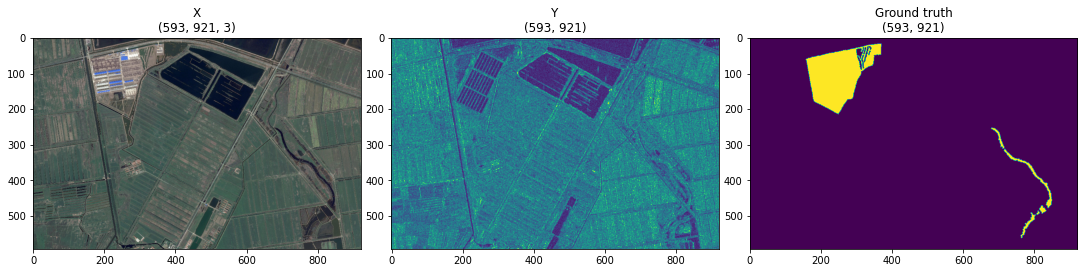

In [6]:
show(
    {'img':X, 'title':'X'},
    {'img':Y, 'title':'Y'},
    {'img':change_true, 'title':'Ground truth'},
    shape=(1,3)
)

## Create difference image

In [7]:
# write image to translate and load translated
to_translate = cv2.resize(X, (256, 256))
to_translate.shape

(256, 256, 3)

In [8]:
cv2.imwrite("to_translate.png", to_translate[:,:,::-1])

True

(256, 256, 1)


(-0.024645803, 0.0640821)

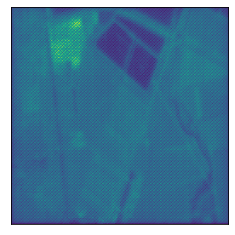

In [9]:
y = np.load("tranlated.npy")
print(y.shape)
fig = plt.imshow(y)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

y.min(), y.max()

In [10]:
# normalize image
y = ((y/np.max([np.abs(y.max()), np.abs(y.min())])) * 127.5 + 127.5)
y = y - y.min()
y = (y/y.max() * 255).astype(np.uint8)
y.min(), y.max()

(0, 255)

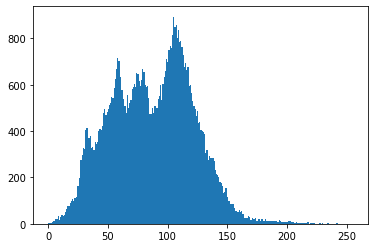

In [11]:
plt.hist(y.flatten(), 256)
plt.show()

In [12]:
X = to_translate
Y = cv2.resize(Y, (256, 256))[:,:,np.newaxis]
Y_ = y
change_true = cv2.resize(change_true, (256, 256))

In [13]:
change_true[100:,180:] = 0

In [14]:
# compute difference image
D = np.abs(Y.astype(np.float32) - Y_.astype(np.float32))
D.min(), D.max()

(0.0, 217.0)

In [15]:
X.shape, Y.shape, Y_.shape, D.shape

((256, 256, 3), (256, 256, 1), (256, 256, 1), (256, 256, 1))

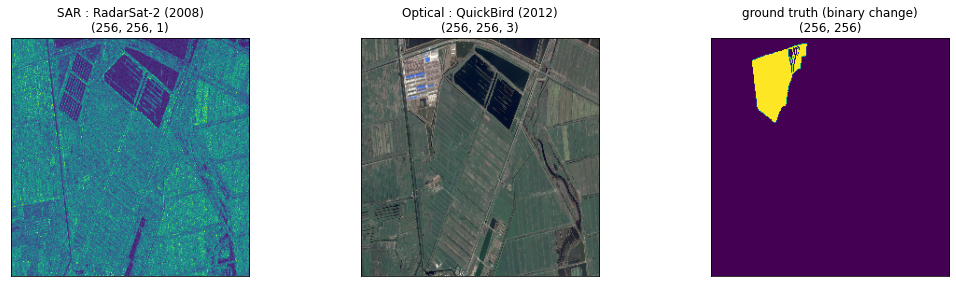

In [16]:
show(
    {'img':Y, 'title':'SAR : RadarSat-2 (2008)', 'axis_visibility':False},
    {'img':X, 'title':'Optical : QuickBird (2012)', 'axis_visibility':False},
    {'img':change_true, 'title':'ground truth (binary change)', 'axis_visibility':False},
    shape=(1,3)
)

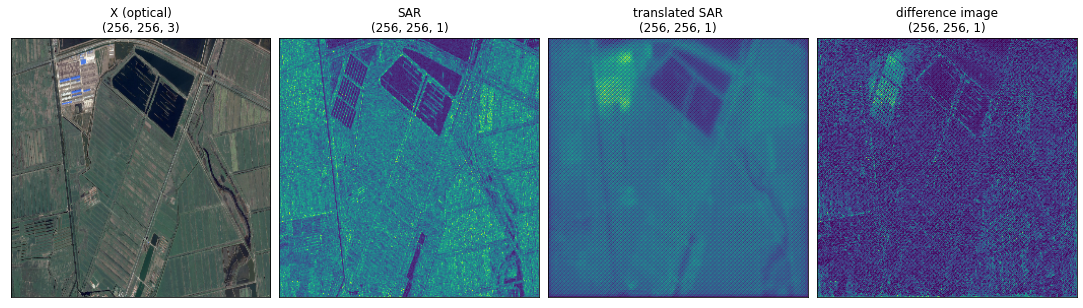

In [17]:
show(
    {'img':X, 'title':'X (optical)', 'axis_visibility':False},
    {'img':Y, 'title':'SAR', 'axis_visibility':False},
    {'img':Y_, 'title':'translated SAR', 'axis_visibility':False},
    {'img':D, 'title':'difference image', 'axis_visibility':False},    
#     {'img':change_true, 'title':'true change (binary)', 'axis_visibility':False},    
    shape=(1, 4),
#     shape=(1, 5),
)

In [18]:
# evaluate translation
psnr = peak_signal_noise_ratio(Y, Y_)
ssim = structural_similarity(Y, Y_, multichannel=True)
psnr, ssim

(14.197935020379939, 0.049805232533715715)

# Change Detection Framework

Framework :
```python
# separate change and non-change
C, C_bar = partition(D, threshold)

# identify clusters corresponding to high significance
C_dist_to_center = compute_dist_to_cluster(C)
C_bar_dist_to_center = compute_dist_to_cluster(C_bar)

# filter out significant changed/unchanged positions
C_positions = filter_and_denoise(C_dist_to_center)
C_bar_positions = filter_and_denoise(C_bar_dist_to_center)

# stack images and create training dataset from identified positions
train_ds, ds = create_dataset([X, Y], C_positions, C_bar_positions)

# train classifier
classifier = ...
classifier.fit(train_ds)

# classify the stacked image's pixels
predictions = classifier.predict(ds)

# aggregate change map
change_map = create_change_map(predictions)
```

In [19]:
# TODO !! when clustering and keeping positions the closest to the center; it lead to ctting of the values that are more extreme (since further away from cluster center)
# an idea would be to take the highest value (uo to some point) to the center and take averything below it in order to include more extreme values ; same respectively other side

In [20]:
# parameters

THRESHOLD = 50  # [0, 255] tipically 125 ; to be chosen to control the number of elements in C and C_bar

N = X.shape[0] * X.shape[1]  # total number of pixels 
N_c = None  # number of pixels in the change partition
N_c_ = None  # number of pixels in the non-change partition

In [21]:
def partition(D, threshold):
    """
    devides the difference image in two partitions (change and non-change) according to a given threshold
    """
    C = np.where(D > threshold, D, np.nan)
    C_bar = np.where(D <= threshold, D, np.nan)
    
    union = np.where(np.isnan(C), C_bar, C)
    return C, C_bar, union

In [22]:
def compute_dist_to_cluster(a, center_of_interest='non-change', train_with_pos=False):
    """
    returns 1) an array of the same shape of 'a' with as values the distance to the center of interest
    and 2) the positions closest to the centroids
    """
    flat_a = np.expand_dims(a.flatten(), axis=-1)
    
    # deal with NaN for KMeans
    flat_a_nonan = np.where(np.isnan(flat_a), 0, flat_a)
    sample_weight = np.where(np.isnan(flat_a), 0, 1)
    
    if train_with_pos:
        coords = np.tile(np.arange(0,a.shape[0]), a.shape[1]).reshape((a.shape[0],a.shape[1]))
        stacked = np.squeeze(np.stack([flat_a, np.expand_dims(coords.T.flatten(), axis=-1), np.expand_dims(coords.flatten(), axis=-1)], axis=-1))
        stacked_nonan = np.where(np.isnan(stacked), 0, stacked)
        kmeans = KMeans(n_clusters=2).fit(stacked_nonan, sample_weight=sample_weight.flatten())
        distances = kmeans.transform(stacked_nonan)
    else:
        kmeans = KMeans(n_clusters=2).fit(flat_a_nonan, sample_weight=sample_weight.flatten())
        distances = kmeans.transform(flat_a_nonan)
    
    # determine which center is the one of the cluster of interest
    if center_of_interest == 'non-change':
        idx_center_of_interest = np.linalg.norm(kmeans.cluster_centers_, axis=1).argmin()
    elif center_of_interest == 'change':
        idx_center_of_interest = np.linalg.norm(kmeans.cluster_centers_, axis=1).argmax()
    
    # make array of same shape (and nan values) as 'a' where the values are the distances to the chosen center
    distance_of_interests = np.where(
        np.isnan(flat_a).flatten(), 
        np.nan, 
        distances[:, idx_center_of_interest]
    ).reshape(a.shape)
    
    # compute postion of centers, mapped back to the shape of 'a'
    if train_with_pos:
        center_positions = np.abs((np.hstack([flat_a_nonan, flat_a_nonan]) - kmeans.cluster_centers_[:,0, np.newaxis].T)).argmin(axis=0)
    else:
        center_positions = np.abs((np.hstack([flat_a_nonan, flat_a_nonan]) - kmeans.cluster_centers_.T)).argmin(axis=0)
    center_positions = np.array([(c_idx//a.shape[1], c_idx%a.shape[1]) for c_idx in center_positions])  # map to original shape
    center_positions = center_positions if idx_center_of_interest == 0 else center_positions[::-1]  # order according to center of interest
    print(
        f"{center_of_interest} centers (first is the one of interest) : \n" +
        f"{str(center_positions)}"

    )

    return distance_of_interests, center_positions

In [23]:
def filter_and_denoise(distances, keep_closest=0):
    flat_dists = distances.flatten()
    sorted_args = np.argsort(np.where(np.isnan(flat_dists), np.inf, flat_dists))
    
    # compute number of positions to keep
    partition_size = len(flat_dists) - np.isnan(flat_dists).sum()
    if keep_closest > 1:
        nb_to_keep = int(min(keep_closest, partition_size))
    else:
        nb_to_keep = int(partition_size * keep_closest)
    
    # create mask of selected positions
    extracted = np.zeros_like(flat_dists, dtype=np.uint8)
    to_keep = sorted_args[:nb_to_keep]
    extracted[to_keep] = np.ones_like(to_keep) * SCALE
    extracted = extracted.reshape(distances.shape)
    
    print(extracted.shape)
    
    # filter isolated pixels with quadratic filtering
    closed = binary_closing(np.squeeze(extracted))
    opened = binary_opening(closed).astype(np.int8) * SCALE
    
    return opened[:,:, np.newaxis]

In [24]:
def create_dataset(images, C_positions, C_bar_positions):
    stacked = np.concatenate(images, axis=-1)

    h, w, d = stacked.shape
    all_pixels = stacked.reshape(h*w, d)

    # get the data samples
    changed_pixels = all_pixels[C_positions.flatten().astype(bool)]
    unchanged_pixels = all_pixels[C_bar_positions.flatten().astype(bool)]
    to_evaluate_pixels = all_pixels[(((C_positions + C_bar_positions) * -1) + SCALE).flatten().astype(bool)]

    changes = np.concatenate([np.ones(len(changed_pixels)), np.zeros(len(unchanged_pixels))])
    pixels = np.concatenate([changed_pixels, unchanged_pixels])

    return (pixels, changes), to_evaluate_pixels, all_pixels

In [25]:
def create_change_map(predictions, shape):
    return predictions.reshape(shape)

## Test on loaded images

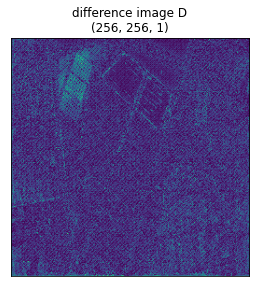

In [26]:
show(
    {'img':D, 'title':'difference image D', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'axis_visibility':False},
#     title='Partition',
    shape=(1, 1),
)

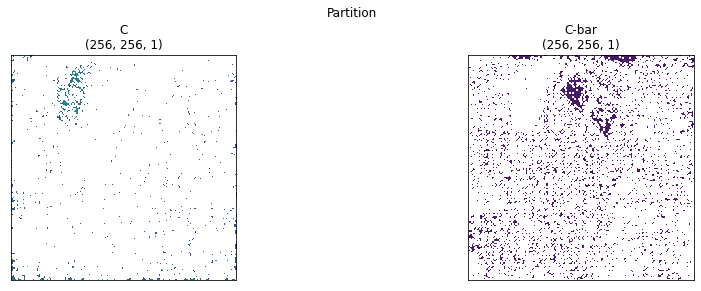

In [27]:
# separate change and non-change
C, C_bar, union = partition(D, 40)
show(
    {'img':C, 'title':'C', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'axis_visibility':False},
    {'img':C_bar, 'title':'C-bar', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'axis_visibility':False},
#     {'img':union, 'title':'U', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'axis_visibility':False},
    title='Partition',
    shape=(1, 2),
)

In [28]:
np.nanmean(C), np.nanmean(C_bar)

(69.44907, 18.964449)

change centers (first is the one of interest) : 
[[  0   2]
 [  0 123]]
non-change centers (first is the one of interest) : 
[[ 0 79]
 [ 0 74]]


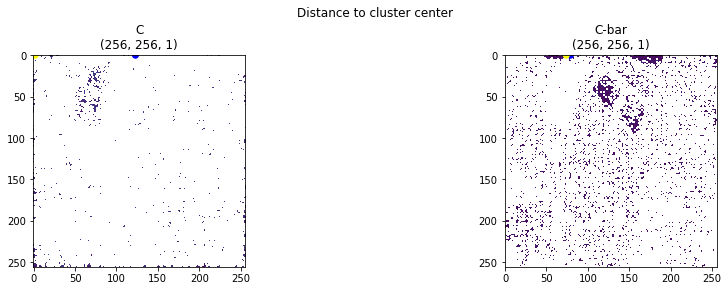

In [29]:
# identify clusters corresponding to high significance
C_dist_to_center, C_center_positions = compute_dist_to_cluster(C, center_of_interest='change', train_with_pos=False)
C_bar_dist_to_center, C_bar_center_positions = compute_dist_to_cluster(C_bar, center_of_interest='non-change')
show(
    {'img':C_dist_to_center, 'title':'C', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'scat':np.fliplr(C_center_positions).T, 'scat_kwargs':{'c':['yellow', 'blue']}},
    {'img':C_bar_dist_to_center, 'title':'C-bar', 'kwargs':{'vmin':0, 'vmax':SCALE}, 'scat':np.fliplr(C_bar_center_positions).T, 'scat_kwargs':{'c':['blue', 'yellow']}},
    title='Distance to cluster center',
    shape=(1, 2),
)

(256, 256, 1)
(256, 256, 1)


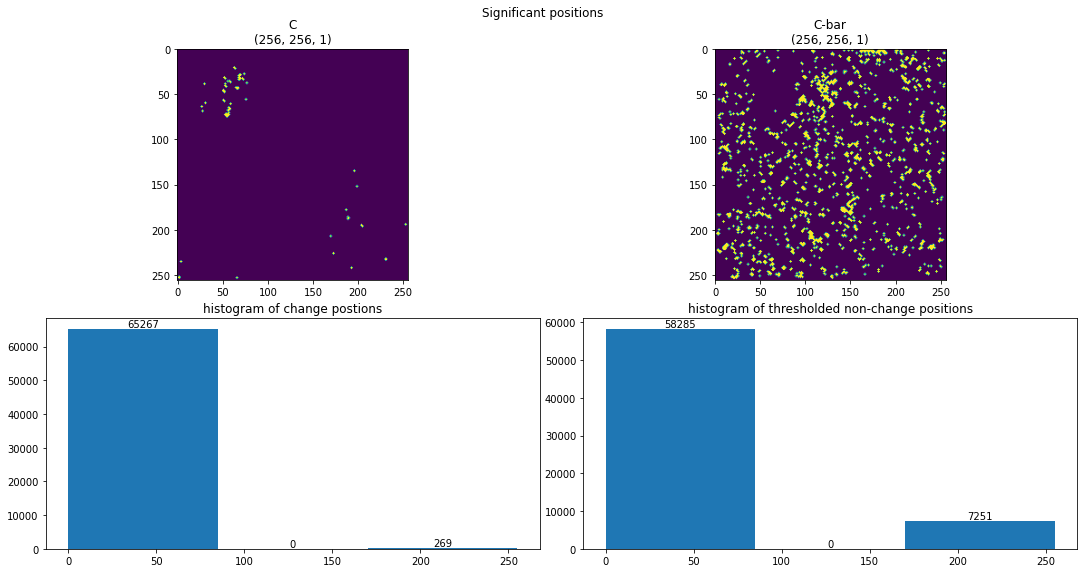

In [30]:
# filter out significant changed/unchanged positions
C_positions = filter_and_denoise(C_dist_to_center, keep_closest=0.15)
C_bar_positions = filter_and_denoise(C_bar_dist_to_center, keep_closest=0.3)
show(
    {'img':C_positions, 'title':'C', 'kwargs':{'vmin':0, 'vmax':SCALE}},
    {'img':C_bar_positions, 'title':'C-bar', 'kwargs':{'vmin':0, 'vmax':SCALE}},
    
    {'hist':C_positions.flatten(), 'title':'histogram of change postions', 'kwargs':{'bins':3}, 'show_values':True},
    {'hist':C_bar_positions.flatten(), 'title':'histogram of thresholded non-change positions', 'kwargs':{'bins':3}, 'show_values':True},

    title='Significant positions',
    shape=(2, 2),
    figsize=(15,8),
)

In [31]:
# stack images and create training dataset from identified positions
# (pixels, changes), to_evaluate_pixels, all_pixels = create_dataset([X, Y[:,:,np.newaxis]], C_positions, C_bar_positions)
(pixels, changes), to_evaluate_pixels, all_pixels = create_dataset([X, Y], C_positions, C_bar_positions)
print(f"There are {len(pixels)} training samples and {len(to_evaluate_pixels)} samples to evaluate (total: {len(pixels) + len(to_evaluate_pixels)}).")

There are 7520 training samples and 58016 samples to evaluate (total: 65536).


In [32]:
# train classifier
classifier = RandomForestClassifier()
classifier.fit(pixels, changes)

RandomForestClassifier()

In [33]:
# classify the stacked image's pixels
predictions = classifier.predict(all_pixels)
# predictions = classifier.predict(to_evaluate_pixels)
print(f"Predicted {len(predictions)} samples.")

Predicted 65536 samples.


In [34]:
# aggregate change map
change_map = create_change_map(predictions, shape=change_true.shape)

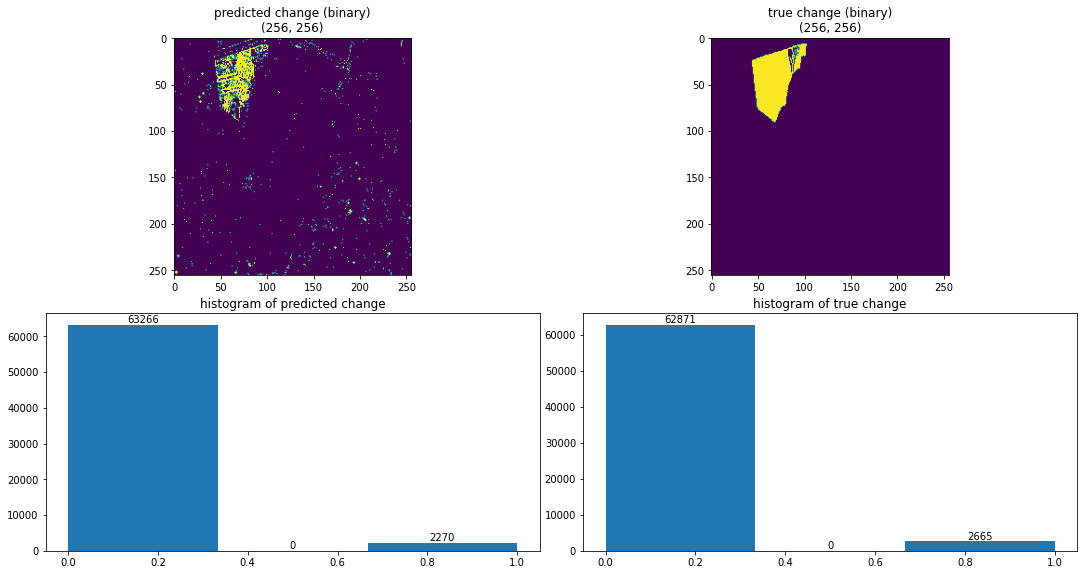

In [35]:
show(
    {'img':change_map, 'title':'predicted change (binary)'},
    {'img':change_true, 'title':'true change (binary)'},
    
    {'hist':change_map.flatten(), 'title':'histogram of predicted change', 'kwargs':{'bins':3}, 'show_values':True},
    {'hist':change_true.flatten(), 'title':'histogram of true change', 'kwargs':{'bins':3}, 'show_values':True},

    shape=(2, 2),
    figsize=(15,8),
)

## Evaluation

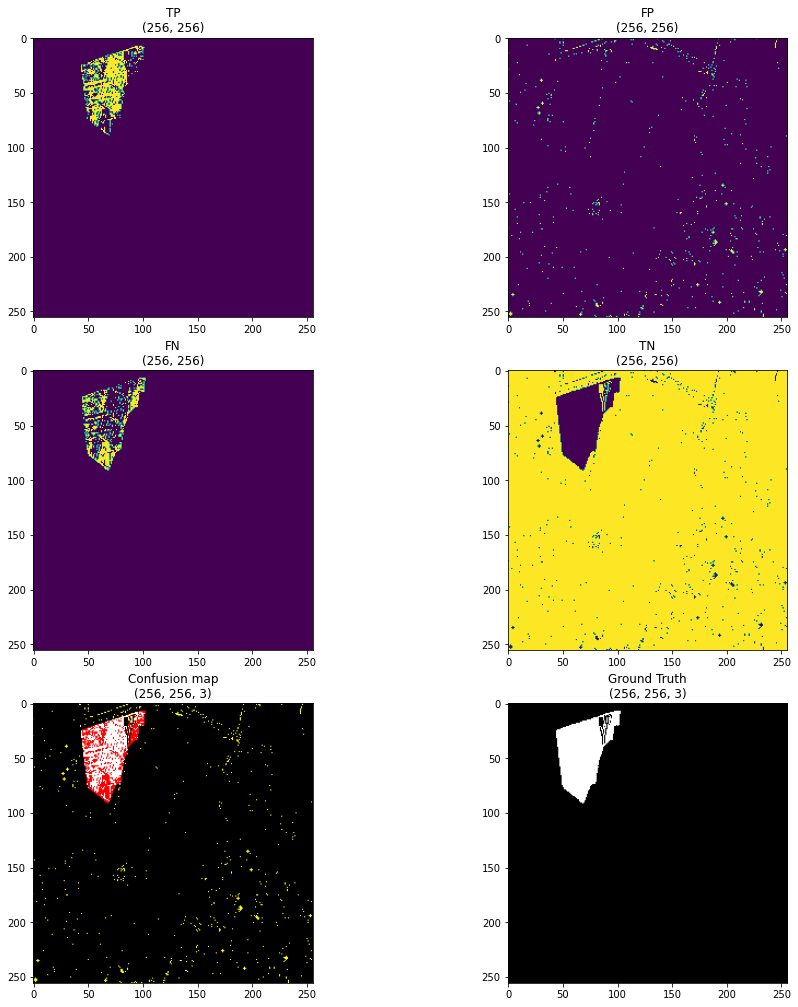

RED    : should have been predicted as change
YELLOW : should have been predicted as non-change


In [36]:
correct_change = change_map * change_true
correct_nonchange = (1-change_map) * (1-change_true)
failed_detecting_change = np.maximum(np.zeros_like(change_true), change_true - change_map)  # FN
failed_predicting_change = np.maximum(np.zeros_like(change_true), change_map - change_true)  # FP

colored_evaluation = np.stack([correct_change]*3, axis=-1)
colored_evaluation[:,:,0] += failed_detecting_change  # red channel
colored_evaluation[:,:,0] += failed_predicting_change  # red and green (= yellow) channel
colored_evaluation[:,:,1] += failed_predicting_change  # red and green (= yellow) channel

show(
    {'img':correct_change, 'title':'TP'},
    {'img':failed_predicting_change, 'title':'FP'},
    {'img':failed_detecting_change, 'title':'FN'},
    {'img':correct_nonchange, 'title':'TN'},
    
    {'img':colored_evaluation, 'title':'Confusion map'},
    {'img':np.stack([change_true*255]*3, axis=-1), 'title':'Ground Truth'},
    
    shape=(3, 2),
    figsize=(15,14),
)
print("RED    : should have been predicted as change")
print("YELLOW : should have been predicted as non-change")

- Overall Accuracy (OA) : accuracy rate of the results - difficult to represent when samples are unbalanced
- Kappa coefficient (KC) : measures the agreement between two classifications
- Intersection over Union (IoU) : also known as the Jaccard Index

In [37]:
def overall_accuracy(true, pred):
    cm = confusion_matrix(true.flatten(), pred.flatten()).ravel()
    tn, fp, fn, tp = cm
    
    return (tp + tn) / (tp + tn + fp + fn)

In [38]:
def kappa_coeff(true, pred):
    cm = confusion_matrix(true.flatten(), pred.flatten()).ravel()
    tn, fp, fn, tp = cm

#     # source : paper
#     pre = ((tp+fp) * (tp+fn) / (tp + tn + fp + fn)**2) + ((fn+tn) * (fp+tn) / (tp + tn + fp + fn))
#     oa = overall_accuracy(tn, fp, fn, tp)
#     return (oa - pre) / (1 - pre)

    # source : wikipedia : https://en.wikipedia.org/wiki/Cohen%27s_kappa
    return (2 * (tp*tn - fn*fp)) / ((tp+fp) * (fp+tn) + (tp+fn) * (fn+tn))

In [39]:
def intersection_over_union(true, pred):
    flat_true = true.flatten().astype(int)
    flat_pred = pred.flatten().astype(int)
    
    i = flat_true * flat_pred
    u = flat_true | flat_pred
    
    return i.sum() / u.sum()

In [40]:
cm = confusion_matrix(change_true.flatten(), change_map.flatten()).ravel()
tn, fp, fn, tp = cm
print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n")

TN: 62137
FP: 734
FN: 1129
TP: 1536



In [41]:
print(overall_accuracy(change_true, change_map))

0.9715728759765625


In [42]:
print(kappa_coeff(change_true, change_map))

0.6078210449366965


In [43]:
print(intersection_over_union(change_true, change_map))

0.45189761694616065
